In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

from sklearn.cluster import KMeans
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage import segmentation 

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools
import mcubes

# code below is commented out since we start with a re-scaled and re-positioned body surface mesh from kidney_files directory

# def plot_slice(image, slice):
#     plt.imshow(image[:, :, slice])
#     plt.colorbar()
#     plt.gray()

#image, voxel_size = phantom_builder.read_dicom('../demos/series-00000/', HU = True, crop = 450, axis = 0)
# opened = phantom_builder.morph_open(image, 5)
# fg_mask = phantom_builder.make_fg_mask(opened, opened.shape[2], fg_threshold = 40)
# fg_mask = phantom_builder.make_fg_mask(opened, opened.shape[2], fg_threshold = 40)
# vertices, triangles = phantom_builder.make_surface_mesh(fg_mask, voxel_size, './abdomen_smoothed.obj')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
voxel_size = np.array([0.00058984, 0.00058984, 0.0005])
surface_mesh = io.read_triangle_mesh("../demos/abdomen_smoothed_scaled.obj")

# idx = [0,1,2]
# np.array(surface_mesh.vertices)[:,idx]
# points = o3d.utility.Vector3dVector(np.array(surface_mesh.vertices)[:,idx])
# surface_mesh.vertices = points

body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [3]:
body_mask.shape

(703, 448, 475)

In [4]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)

kidney_file_dir = "../demos/kidney_files/"
kidney_tissue_list = [blood, connective, cortex, cortex, blood, medulla, medulla]

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('fat')

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


In [5]:
test = test_phantom.get_complete()


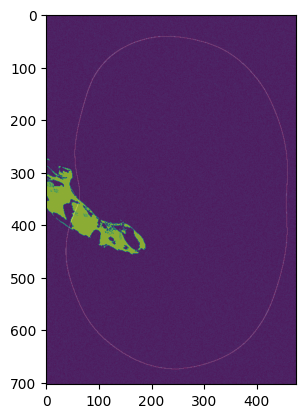

In [6]:
plt.imshow(test[0, :,200, :])
plt.imshow(body_mask[:,200, :] * 1000, alpha=0.2, cmap='Reds_r')

In [8]:
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/3,
                                    ray_num = 32, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

test_transducer_set.place_transducer_by_voxel(0, surface_mesh, np.pi/2, [400,600,330], voxel_size[0])

test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)


NameError: name 'open3d' is not defined

In [ ]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [ ]:
simprops = simulation.SimProperties(
                grid_size   = (150e-3,40e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [ ]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [ ]:
test_experiment.plot_ray_path(15)

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_01')
test_experiment.run(dry=True)

In [ ]:
test_experiment.run(repeat=True)